# 1. Import

In [1]:
# 연산 처리를 위한 패키지
import numpy as np
import pandas as pd
from pandas import DataFrame
from math import sqrt

# 데이터 분석을 위한 패키지
import statsmodels.api as sm

# 시각화를 위한 패키지
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# 필요모듈 import
import os
import openpyxl
from datetime import datetime
from tqdm import tqdm

# 그래프를 실제로 그리기 위한 설정
%matplotlib inline

# 머신러닝 패키지
from catboost import CatBoostRegressor
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm.sklearn import LGBMRegressor
import random
import optuna
from optuna.samplers import TPESampler
# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold
from functools import partial

# 폰트 처리
# plt.rc('font', family='NanumGothic')        # for windows
plt.rc('font', family='AppleGothic') # For MacOS

import warnings
warnings.filterwarnings('ignore')

# 2.1. 데이터 로딩

In [2]:
# 뉴 데이터 로딩
test = pd.read_csv('data/final_test.csv', index_col = 0)             # unnamed_0 이라는 index가 추가되어 나오지 않게 'index_col = 0' 을 추가했습니다.
train = pd.read_csv('data/final_train.csv', index_col = 0)

submission = pd.read_csv('data/sample_submission.csv')

train2 = train.copy()
train.head()

,index,송하인_격자공간고유번호,송하인_격자공간명,송하인_시도코드,송하인_시도명,송하인_시군구코드,송하인_시군구명,수하인_격자공간고유번호,수하인_격자공간명,수하인_시도코드,수하인_시도명,수하인_시군구코드,수하인_시군구명,물품_카테고리,운송장_건수
0,0,5011000595017300,다나1395,50,제주특별자치도,50110,제주시,2871000192069300,다사1072,28,인천광역시,28710,강화군,음반,3
1,1,4148000690043300,다사2868,41,경기도,41480,파주시,5011000264024400,다다0901,50,제주특별자치도,50110,제주시,문화컨텐츠,3
2,2,5011000078068400,다다3007,50,제주특별자치도,50110,제주시,1120000007005400,다사5950,11,서울특별시,11200,성동구,농산물,3
3,3,4127100048006400,다사4521,41,경기도,41271,안산시상록구,5011000587019400,다나0595,50,제주특별자치도,50110,제주시,기타식품,7
4,4,5011000078068400,다다3007,50,제주특별자치도,50110,제주시,2823700010076300,다사3145,28,인천광역시,28237,부평구,농산물,3


In [3]:
def setting_data(train, test, one, two, three, four, five, six):
  test['송하인_격자공간고유번호'] = test['송하인_격자공간고유번호'].astype(str)
  test['수하인_격자공간고유번호'] = test['수하인_격자공간고유번호'].astype(str)
  train['송하인_격자공간고유번호'] = train['송하인_격자공간고유번호'].astype(str)
  train['수하인_격자공간고유번호'] = train['수하인_격자공간고유번호'].astype(str)

  train['송하인_코드1'] = train['송하인_격자공간고유번호'].str.slice(int(one),int(two))
  train['송하인_코드2'] = train['송하인_격자공간고유번호'].str.slice(int(two),int(three))
  train['송하인_코드3'] = train['송하인_격자공간고유번호'].str.slice(int(three),int(four))
  train['송하인_코드4'] = train['송하인_격자공간고유번호'].str.slice(int(four),int(five))
  train['송하인_코드5'] = train['송하인_격자공간고유번호'].str.slice(int(five),int(six))

  train['수하인_코드1'] = train['수하인_격자공간고유번호'].str.slice(int(one),int(two))
  train['수하인_코드2'] = train['수하인_격자공간고유번호'].str.slice(int(two),int(three))
  train['수하인_코드3'] = train['수하인_격자공간고유번호'].str.slice(int(three),int(four))
  train['수하인_코드4'] = train['수하인_격자공간고유번호'].str.slice(int(four),int(five))
  train['수하인_코드5'] = train['수하인_격자공간고유번호'].str.slice(int(five),int(six))

  test['송하인_코드1'] = test['송하인_격자공간고유번호'].str.slice(int(one),int(two))
  test['송하인_코드2'] = test['송하인_격자공간고유번호'].str.slice(int(two),int(three))
  test['송하인_코드3'] = test['송하인_격자공간고유번호'].str.slice(int(three),int(four))
  test['송하인_코드4'] = test['송하인_격자공간고유번호'].str.slice(int(four),int(five))
  test['송하인_코드5'] = test['송하인_격자공간고유번호'].str.slice(int(five),int(six))

  test['수하인_코드1'] = test['수하인_격자공간고유번호'].str.slice(int(one),int(two))
  test['수하인_코드2'] = test['수하인_격자공간고유번호'].str.slice(int(two),int(three))
  test['수하인_코드3'] = test['수하인_격자공간고유번호'].str.slice(int(three),int(four))
  test['수하인_코드4'] = test['수하인_격자공간고유번호'].str.slice(int(four),int(five))
  test['수하인_코드5'] = test['수하인_격자공간고유번호'].str.slice(int(five),int(six))

  train = train[['index', 
                  '송하인_코드1','송하인_시도명',
                  '송하인_코드2', '송하인_시군구명',
                  '송하인_코드3', '송하인_코드4', '송하인_코드5',
                  
                  '수하인_코드1', '수하인_시도명',
                  '수하인_코드2', '수하인_시군구명',
                  '수하인_코드3', '수하인_코드4', '수하인_코드5',
                  '물품_카테고리', 
                  '운송장_건수']]

  test = test[['index',
                '송하인_코드1','송하인_시도명',
                '송하인_코드2', '송하인_시군구명', 
                '송하인_코드3', '송하인_코드4', '송하인_코드5',

                '수하인_코드1', '수하인_시도명',
                '수하인_코드2', '수하인_시군구명',
                '수하인_코드3', '수하인_코드4', '수하인_코드5',
                '물품_카테고리',
                ]]
                
  return train, test


In [4]:
def confirm_nun(train):
  print('송하인 코드 1, 2, 3, 4, 5는 각각 ~ 종류의 코드가 존재합니다.')
  print('코드_1 :', train['송하인_코드1'].nunique())
  print('코드_2 :', train['송하인_코드2'].nunique())
  print('코드_3 :', train['송하인_코드3'].nunique())
  print('코드_4 :', train['송하인_코드4'].nunique())
  print('코드_5 :', train['송하인_코드5'].nunique())

  print("*"*50)

  print('수하인 코드 1, 2, 3, 4, 5는 각각 ~ 종류의 코드가 존재합니다.')
  print('코드_1 :', train['수하인_코드1'].nunique())
  print('코드_2 :', train['수하인_코드2'].nunique())
  print('코드_3 :', train['수하인_코드3'].nunique())
  print('코드_4 :', train['수하인_코드4'].nunique())
  print('코드_5 :', train['수하인_코드5'].nunique())

  print('*'*50)
  print('수하인_코드4의 고유값은')
  print(train['수하인_코드4'].unique())


In [5]:
train1, test1 = setting_data(train, test, '0', '2', '5', '8', '10', '16')       # 0, 2, 5, 9, 10, 16번째 위치에서 코드를 잘라서 저장합니다. 이걸로 결정
train2, test2 = setting_data(train, test, '0', '2', '5', '10', '11', '16')      # 0, 2, 5, 10, 11, 16번째 위치에서 코드를 잘라서 저장합니다.

### train3은 16자리중 15,16번째 숫자들을 쳐내는 과정입니다.
### 전부 00 이라는 값을 가지기 때문에 학습할 때 제거해도 상관없다고 생각합니다.

In [6]:
train1

,index,송하인_코드1,송하인_시도명,송하인_코드2,송하인_시군구명,송하인_코드3,송하인_코드4,송하인_코드5,수하인_코드1,수하인_시도명,수하인_코드2,수하인_시군구명,수하인_코드3,수하인_코드4,수하인_코드5,물품_카테고리,운송장_건수
0,0,50,제주특별자치도,110,제주시,005,95,017300,28,인천광역시,710,강화군,001,92,069300,음반,3
1,1,41,경기도,480,파주시,006,90,043300,50,제주특별자치도,110,제주시,002,64,024400,문화컨텐츠,3
2,2,50,제주특별자치도,110,제주시,000,78,068400,11,서울특별시,200,성동구,000,07,005400,농산물,3
3,3,41,경기도,271,안산시상록구,000,48,006400,50,제주특별자치도,110,제주시,005,87,019400,기타식품,7
4,4,50,제주특별자치도,110,제주시,000,78,068400,28,인천광역시,237,부평구,000,10,076300,농산물,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31679,31679,44,충청남도,710,금산군,002,90,087200,50,제주특별자치도,110,제주시,002,13,073200,스포츠잡화,3
31680,31680,11,서울특별시,290,성북구,000,14,045300,50,제주특별자치도,110,제주시,003,19,087100,스마트디바이스,4
31681,31681,11,서울특별시,290,성북구,000,14,045300,50,제주특별자치도,110,제주시,002,63,065200,스마트디바이스,6
31682,31682,41,경기도,273,안산시단원구,000,65,073100,50,제주특별자치도,110,제주시,002,64,061200,지갑,7


In [7]:
confirm_nun(train1)

송하인 코드 1, 2, 3, 4, 5는 각각 ~ 종류의 코드가 존재합니다.
코드_1 : 17
코드_2 : 99
코드_3 : 14
코드_4 : 100
코드_5 : 400
**************************************************
수하인 코드 1, 2, 3, 4, 5는 각각 ~ 종류의 코드가 존재합니다.
코드_1 : 17
코드_2 : 101
코드_3 : 18
코드_4 : 100
코드_5 : 400
**************************************************
수하인_코드4의 고유값은
['92' '64' '07' '87' '10' '14' '69' '17' '23' '26' '16' '20' '63' '02'
 '27' '21' '96' '09' '48' '31' '03' '18' '06' '39' '24' '55' '04' '33'
 '35' '72' '56' '79' '30' '12' '59' '99' '41' '15' '62' '73' '32' '65'
 '70' '82' '74' '94' '46' '19' '78' '29' '52' '25' '85' '42' '13' '01'
 '08' '28' '05' '90' '53' '60' '66' '11' '77' '88' '00' '67' '98' '54'
 '44' '37' '36' '38' '81' '84' '58' '34' '68' '40' '57' '71' '83' '45'
 '49' '76' '47' '51' '43' '93' '61' '22' '86' '95' '50' '75' '97' '89'
 '91' '80']


In [8]:
print('*'*50)
print('수하인_코드2의 고유값은')
print(test1['수하인_코드2'].unique())

**************************************************
수하인_코드2의 고유값은
['110' '260' '130' '710' '480' '350' '465' '200' '210' '185' '173' '170'
 '570' '560' '440' '810' '470' '113' '237' '410' '390' '650' '590' '800'
 '500' '380' '900' '790' '360' '140' '430' '320' '680' '463' '111' '545'
 '770' '290' '780' '610' '150' '190' '285' '820' '330' '305' '230' '530'
 '135' '197' '310' '287' '270' '370' '131' '281' '450' '133' '750' '280'
 '740' '117' '180' '880' '220' '620' '199' '125' '830' '245' '250' '760'
 '129' '273' '155' '121' '115' '271' '850' '840' '550' '215' '195' '127'
 '123' '730' '461' '670' '630' '171' '870' '720' '890' '910' '240' '825'
 '860' '930' '745' '940' '920']


In [9]:
'''
종로구 : 110
중구 : 140
용산구 : 170
성동구 : 200
광진구 : 215
동대문구 : 230
중랑구 : 260
성북구 : 290
'''
train1[(train1['송하인_시군구명']=='강남구')&(train1['송하인_시도명']=='서울특별시')]

,index,송하인_코드1,송하인_시도명,송하인_코드2,송하인_시군구명,송하인_코드3,송하인_코드4,송하인_코드5,수하인_코드1,수하인_시도명,수하인_코드2,수하인_시군구명,수하인_코드3,수하인_코드4,수하인_코드5,물품_카테고리,운송장_건수
210,210,11,서울특별시,680,강남구,000,07,002200,50,제주특별자치도,110,제주시,003,73,011400,선글라스/안경테,3
213,213,11,서울특별시,680,강남구,000,15,064300,50,제주특별자치도,110,제주시,002,66,003200,기타화장품/미용,3
505,505,11,서울특별시,680,강남구,000,12,065400,50,제주특별자치도,110,제주시,003,19,002300,상의,3
750,750,11,서울특별시,680,강남구,000,10,070300,50,제주특별자치도,110,제주시,002,13,022200,상의,4
881,881,11,서울특별시,680,강남구,000,12,071300,50,제주특별자치도,130,서귀포시,006,22,057100,농산물,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30659,30659,11,서울특별시,680,강남구,000,16,020100,50,제주특별자치도,130,서귀포시,005,79,077400,기타패션의류,3
30806,30806,11,서울특별시,680,강남구,000,11,040100,50,제주특별자치도,110,제주시,002,66,031300,다이어트식품,5
31514,31514,11,서울특별시,680,강남구,000,32,011100,50,제주특별자치도,110,제주시,003,74,015300,기타패션의류,4
31599,31599,11,서울특별시,680,강남구,000,11,068300,50,제주특별자치도,110,제주시,002,66,060300,주얼리,4


In [10]:
train1[train1['송하인_시도명']=='서울특별시']['송하인_코드2'].sort_values().unique()

array(['110', '140', '170', '200', '215', '230', '260', '290', '305',
       '320', '350', '380', '410', '440', '470', '500', '530', '545',
       '560', '590', '620', '650', '680', '710', '740'], dtype=object)

In [11]:
train1[(train1['송하인_시군구명']=='용산구')&(train1['물품_카테고리']=='기타디지털/가전')]

,index,송하인_코드1,송하인_시도명,송하인_코드2,송하인_시군구명,송하인_코드3,송하인_코드4,송하인_코드5,수하인_코드1,수하인_시도명,수하인_코드2,수하인_시군구명,수하인_코드3,수하인_코드4,수하인_코드5,물품_카테고리,운송장_건수
152,152,11,서울특별시,170,용산구,000,09,037100,50,제주특별자치도,110,제주시,002,64,100200,기타디지털/가전,3
403,403,11,서울특별시,170,용산구,000,09,058400,50,제주특별자치도,110,제주시,003,78,017100,기타디지털/가전,3
562,562,11,서울특별시,170,용산구,000,09,037100,50,제주특별자치도,110,제주시,003,18,029400,기타디지털/가전,3
608,608,11,서울특별시,170,용산구,000,09,037100,50,제주특별자치도,110,제주시,003,19,033100,기타디지털/가전,5
1046,1046,11,서울특별시,170,용산구,000,09,037100,50,제주특별자치도,110,제주시,004,35,063100,기타디지털/가전,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31172,31172,11,서울특별시,170,용산구,000,09,037100,50,제주특별자치도,110,제주시,004,35,073100,기타디지털/가전,4
31197,31197,11,서울특별시,170,용산구,000,09,070100,50,제주특별자치도,130,서귀포시,008,66,019400,기타디지털/가전,4
31376,31376,11,서울특별시,170,용산구,000,09,037100,50,제주특별자치도,110,제주시,003,74,018100,기타디지털/가전,3
31487,31487,11,서울특별시,170,용산구,000,09,037100,50,제주특별자치도,110,제주시,002,65,076100,기타디지털/가전,28


In [12]:
train1[(train1['송하인_시군구명']=='용산구')&(train1['물품_카테고리']=='기타디지털/가전')]['송하인_코드4'].sort_values().unique()

array(['08', '09'], dtype=object)

In [13]:
train1[train1['송하인_시군구명']=='용산구']['송하인_코드4'].sort_values().unique()

array(['01', '02', '03', '05', '08', '09', '10', '12', '13', '15', '18',
       '22', '23'], dtype=object)

In [14]:
# train1(5416), train2(5416)으로 나눠서 각자 고유값들을 확인해봤는데요,
# 5515의 경우 1부분이 [0,1]만 존재하는걸로 봐서, 맨 뒷자리 5와 이어진다고 생각했습니다
# 99999에서 100000 으로 넘어가기 때문에 이런식으로 나왔다고 생각했고,
# 우리나라 좌표에 고유번호를 50미터 단위로 지정을 했기 때문에, 정사각형 격자를 만들려면 제곱수가 나와야 한다고 생각했습니다.
# 때문에 6자리수 안에 들어갈 수 있는 데이터는 100만개로 제곱수이며, 5자리수 안에 들어갈 수 있는 데이터는 10만개로 제곱수가 되지 않아 합리적인 수가 아니라고 생각했습니다.
# 또, 6자리수 맨 뒷자리 2자리는 모두 00이어서, 4자리수만 데이터에 의미가 있는 것으로 보입니다. 
# 우리는 5 4 1 6(4) 단위로 끊어서 데이터를 분석하기로 했습니다.

In [15]:
train = train1[['물품_카테고리', '송하인_코드1', '송하인_코드2', '송하인_코드3', '송하인_코드4','송하인_코드5', '수하인_코드1', '수하인_코드2', '수하인_코드3', '수하인_코드4', '수하인_코드5', '운송장_건수']]
test = test1[['물품_카테고리', '송하인_코드1', '송하인_코드2', '송하인_코드3', '송하인_코드4','송하인_코드5', '수하인_코드1', '수하인_코드2', '수하인_코드3', '수하인_코드4', '수하인_코드5']]


In [16]:
for col in test.columns:
  train[col]=train[col].astype('category')
  test[col]=test[col].astype('category')

In [17]:
train.head()

,물품_카테고리,송하인_코드1,송하인_코드2,송하인_코드3,송하인_코드4,송하인_코드5,수하인_코드1,수하인_코드2,수하인_코드3,수하인_코드4,수하인_코드5,운송장_건수
0,음반,50,110,005,95,017300,28,710,001,92,069300,3
1,문화컨텐츠,41,480,006,90,043300,50,110,002,64,024400,3
2,농산물,50,110,000,78,068400,11,200,000,07,005400,3
3,기타식품,41,271,000,48,006400,50,110,005,87,019400,7
4,농산물,50,110,000,78,068400,28,237,000,10,076300,3


In [18]:
# 결측치가 있는 column
train[train.isnull().any(axis=1)]

,물품_카테고리,송하인_코드1,송하인_코드2,송하인_코드3,송하인_코드4,송하인_코드5,수하인_코드1,수하인_코드2,수하인_코드3,수하인_코드4,수하인_코드5,운송장_건수


In [19]:
test[test.isnull().any(axis=1)]

,물품_카테고리,송하인_코드1,송하인_코드2,송하인_코드3,송하인_코드4,송하인_코드5,수하인_코드1,수하인_코드2,수하인_코드3,수하인_코드4,수하인_코드5


In [20]:
categorical_features = train.columns[0:11]
categorical_features

Index(['물품_카테고리', '송하인_코드1', '송하인_코드2', '송하인_코드3', '송하인_코드4', '송하인_코드5',
       '수하인_코드1', '수하인_코드2', '수하인_코드3', '수하인_코드4', '수하인_코드5'],
      dtype='object')

In [21]:
temp = train.columns[12:]
temp

Index([], dtype='object')

In [22]:
card1 = train.columns[train.nunique() == 1]
card1

Index([], dtype='object')

In [23]:
binary_features = np.setdiff1d(temp, card1)
print("%d features - %d features = %d binary features" % (len(temp), len(card1), len(binary_features)))

0 features - 0 features = 0 binary features


In [24]:
# feature engineering을 위해 tempX, y 생성
total = pd.concat([train, test])
split_point = len(train)
total_OHE = pd.get_dummies(data=total, columns=categorical_features)
y = train.운송장_건수
tempX = total_OHE.drop(columns=["운송장_건수"])
tempX = tempX.drop(columns=card1)
trainX = tempX[:split_point]
testX = tempX[split_point:]
print(trainX.shape, testX.shape, y.shape)

(31684, 1367) (7920, 1367) (31684,)


In [25]:
trainX # sponge

,물품_카테고리_DIY자재/용품,물품_카테고리_PC,물품_카테고리_PC주변기기,물품_카테고리_가공식품,물품_카테고리_가방,물품_카테고리_건강식품,물품_카테고리_건강용품,물품_카테고리_게임기/타이틀,물품_카테고리_계절가전,물품_카테고리_골프,...,수하인_코드5_098300,수하인_코드5_098400,수하인_코드5_099100,수하인_코드5_099200,수하인_코드5_099300,수하인_코드5_099400,수하인_코드5_100100,수하인_코드5_100200,수하인_코드5_100300,수하인_코드5_100400
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31679,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31680,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31681,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31682,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
testX

,물품_카테고리_DIY자재/용품,물품_카테고리_PC,물품_카테고리_PC주변기기,물품_카테고리_가공식품,물품_카테고리_가방,물품_카테고리_건강식품,물품_카테고리_건강용품,물품_카테고리_게임기/타이틀,물품_카테고리_계절가전,물품_카테고리_골프,...,수하인_코드5_098300,수하인_코드5_098400,수하인_코드5_099100,수하인_코드5_099200,수하인_코드5_099300,수하인_코드5_099400,수하인_코드5_100100,수하인_코드5_100200,수하인_코드5_100300,수하인_코드5_100400
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7915,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7916,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7918,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# 1. correlation

# 중복정보가 있는 column 제거하기 위해 상관계수를 확인해봅니다.
def remove_collinearity(X, threshold):
    """
    X : feature matrix
    threshold : 다중공선성을 제거할 column을 고르는 기준 값. [0, 1]
    """
    
    corr = X.corr()
    candidate_cols = []
    
    for x in corr.iterrows():
        idx, row = x[0], x[1] # decoupling tuple
        # 해당 row는 이미 처리가 되어서 볼 필요가 없다.
        if idx in candidate_cols:
            continue
        #print(row[row > 0.7].index[1:])
        candidates = row[row > threshold].index[1:]

        # 자기 자신을 제외하고 threshold를 넘는 column이 있다면,
        if len(candidates) != 0:
            for col in candidates:
                candidate_cols.append(col)           
    
    return candidate_cols

def find_feature_importance(X, model, show_plot):

    feat_names = X.columns.values
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    indices = np.argsort(importances)[::-1][:20]

    plt.figure(figsize=(12,12))
    plt.title("Feature importances")
    plt.bar(range(len(indices)), importances[indices], color="r", align="center")
    plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
    plt.xlim([-1, len(indices)])
    plt.show()
    
    important_features = X.columns[importances >= 0.005]
    return important_features
    
def apply_PCA(X, show_plot):
    from sklearn.decomposition import PCA
    # training data와 test data를 모두 PCA를 이용하여 차원 감소를 수행합니다.
    pca = PCA(n_components=0.90) # 원래 데이터의 90%를 보존하는 차원.
    pca_090 = pca.fit(X) # 학습 및 변환
    reduced_X = pca_090.transform(X)
    print(reduced_X.shape)
    
    if show_plot:
        labels = [f"PC{x}" for x in range(1, reduced_X.shape[1]+1)]
        pca_090_variance = np.round(pca_090.explained_variance_ratio_.cumsum()*100, decimals=1)
        plt.figure(figsize=(25,5))
        plt.bar(x=range(1, len(pca_090_variance)+1), height=pca_090_variance, tick_label=labels)

        plt.xticks(rotation=90, color='indigo', size=15)
        plt.yticks(rotation=0, color='indigo', size=15)
        plt.title('Scree Plot',color='tab:orange', fontsize=25)
        plt.xlabel('Principal Components', {'color': 'tab:orange', 'fontsize':15})
        plt.ylabel('Cumulative percentage of explained variance ', {'color': 'tab:orange', 'fontsize':15})
        plt.show()
        
        X_train_pca_df = pd.DataFrame(reduced_X, columns=labels)
        display(X_train_pca_df)

    return pca_090, X_train_pca_df

In [28]:
# flag setting
feature_reducing = "PCA" # "correlation" / "feature_importance" / "PCA"

(31684, 600)


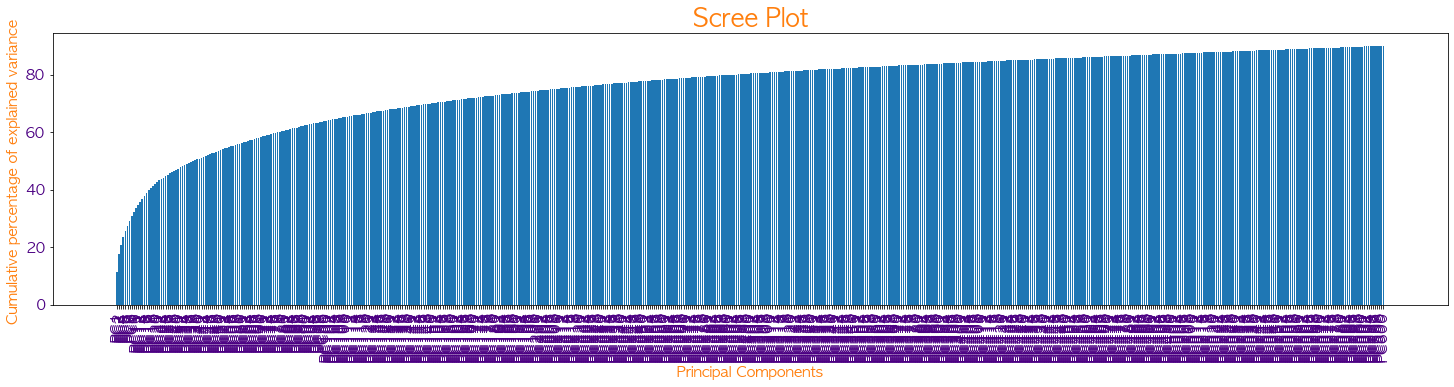

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC591,PC592,PC593,PC594,PC595,PC596,PC597,PC598,PC599,PC600
0,-0.009858,0.477805,0.806920,-0.460605,-0.008932,-0.376285,-0.368366,-0.551784,-0.350214,-0.196455,...,0.026411,0.005203,-0.007162,0.020368,-0.024257,-0.037374,0.000111,0.000452,-0.001660,0.001264
1,1.892558,-0.442629,0.209595,0.463680,0.931256,-0.003160,0.104123,0.426147,-0.541082,-0.793139,...,-0.027845,0.037963,0.021958,-0.033990,0.014638,-0.038212,-0.000540,-0.016687,0.006691,0.015321
2,-0.870839,1.339358,-0.716104,0.796148,-0.230227,-0.350980,-0.001632,0.033271,-0.067134,-0.031889,...,0.016531,-0.021727,0.012617,-0.001054,-0.016560,0.002001,0.001987,0.011630,0.006948,0.001835
3,1.797593,0.152652,-0.366415,0.224401,-0.181880,0.176665,-0.025971,-0.028135,0.098604,-0.169076,...,0.031803,0.045233,0.013933,-0.011830,0.022162,-0.007963,-0.007977,0.016892,0.017083,-0.005302
4,-0.769998,1.346103,-0.794740,0.421177,-0.047480,-0.119300,-0.034892,0.105987,-0.114239,0.067393,...,-0.007192,-0.010914,-0.002918,-0.005521,-0.005322,0.012807,0.014331,-0.023190,0.023133,0.009645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31679,1.539609,-0.145747,0.254914,-0.075059,-0.040440,0.096006,0.101783,-0.320448,0.096545,-0.817094,...,0.004822,-0.005462,0.046200,0.016076,-0.027957,0.012462,0.001775,-0.015110,0.032851,0.034257
31680,1.733757,0.205105,-0.526886,0.091672,-0.259832,0.070444,0.514069,-0.541155,0.249785,0.323154,...,0.071341,0.073208,0.048627,0.084643,0.075340,0.005024,-0.043938,-0.137289,0.084853,0.040782
31681,1.653511,0.212362,-0.523760,0.025188,-0.220642,0.179585,0.003923,-0.455266,0.590354,-0.870691,...,0.023452,-0.006976,-0.032508,0.025069,0.013470,-0.013600,-0.009110,-0.002383,-0.015368,0.000242
31682,1.847377,0.145054,-0.432200,0.113646,-0.122051,0.220145,0.047331,-0.063591,0.259991,-0.823434,...,-0.016196,-0.009939,-0.010972,0.040088,0.004693,0.004791,-0.004334,0.022164,-0.000340,-0.051259


(31684, 600)


In [29]:
# PCA 적용
if feature_reducing == "correlation":
    threshold = 0.7
    correlated_features = remove_collinearity(trainX, threshold)
    correlated_features = set(correlated_features) # 중복 제거
    print("%d Correlation features over %.2f" % (len(correlated_features), threshold))
    
    X = trainX.drop(columns=correlated_features)
    print(X.shape)
    
elif feature_reducing == "feature_importance":
    show_plot = True
    model = RandomForestRegressor(max_features="sqrt", n_jobs=-1, random_state=0xC0FFEE)
    model.fit(trainX, y)
    important_features = find_feature_importance(trainX, model, show_plot)
    X = trainX[important_features]
    print(X.shape)
    
elif feature_reducing == "PCA":
    show_plot = True
    pca_model, X = apply_PCA(trainX, show_plot)
    print(X.shape)

In [30]:
# 첫번째 테스트용으로 사용하고, 실제 학습시에는 K-Fold CV를 사용합니다.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0xC0FFEE)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(28515, 600) (3169, 600) (28515,) (3169,)


In [31]:
print("\nFitting Random Forest...")
model = RandomForestRegressor(max_features='sqrt', n_jobs=-1)
model.fit(X_train, y_train)


Fitting Random Forest...


RandomForestRegressor(max_features='sqrt', n_jobs=-1)

In [32]:
# metric은 그때마다 맞게 바꿔줘야 합니다.
from sklearn.metrics import r2_score
evaluation_metric = r2_score

In [33]:
print("Prediction")
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)


train_score = evaluation_metric(y_train, pred_train)
test_score = evaluation_metric(y_test, pred_test)

print("Train Score : %.4f" % train_score)
print("Test Score : %.4f" % test_score)

Prediction
Train Score : 0.8766
Test Score : -0.0078


In [34]:
# For Regression

def optimizer(trial, X, y, K):
    # 조절할 hyper-parameter 조합을 적어줍니다.
    n_estimators = trial.suggest_int("n_estimators", 50, 200)
    max_depth = trial.suggest_int("max_depth", 8, 30)
    max_features = trial.suggest_categorical("max_features", ['auto', 'sqrt', 'log2'])
    
    
    # 원하는 모델을 지정합니다, optuna는 시간이 오래걸리기 때문에 저는 보통 RF로 일단 테스트를 해본 뒤에 LGBM을 사용합니다.
    model = RandomForestRegressor(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  max_features=max_features,
                                  n_jobs=-1,
                                  random_state=0xC0FFEE)
    
    
    # K-Fold Cross validation을 구현합니다.
    folds = KFold(n_splits=K)
    scores = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        score = evaluation_metric(y_val, preds)
        scores.append(score)
    
    
    # K-Fold의 평균 loss값을 돌려줍니다.
    return np.mean(scores)

In [35]:
K = 5 # Kfold 수
opt_func = partial(optimizer, X=X_train, y=y_train, K=K)

rf_study = optuna.create_study(study_name="RF", direction="maximize") # regression task에서 R^2를 최대화!
rf_study.optimize(opt_func, n_trials=30)

[I 2022-06-13 19:09:43,283] A new study created in memory with name: RF
[I 2022-06-13 19:11:01,304] Trial 0 finished with value: 0.12119993912398672 and parameters: {'n_estimators': 152, 'max_depth': 27, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.12119993912398672.
[I 2022-06-13 19:11:22,183] Trial 1 finished with value: 0.09910321718136979 and parameters: {'n_estimators': 107, 'max_depth': 9, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.12119993912398672.
[I 2022-06-13 19:13:01,222] Trial 2 finished with value: 0.12726673111381515 and parameters: {'n_estimators': 194, 'max_depth': 28, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.12726673111381515.
[I 2022-06-13 19:13:16,502] Trial 3 finished with value: 0.09924785625485218 and parameters: {'n_estimators': 192, 'max_depth': 10, 'max_features': 'log2'}. Best is trial 2 with value: 0.12726673111381515.
[I 2022-06-13 19:13:38,382] Trial 4 finished with value: 0.11166008731745561 and parameters: {'n_estimato

KeyboardInterrupt: 

In [36]:
# optuna가 시도했던 모든 실험 관련 데이터
rf_study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_max_depth,params_max_features,params_n_estimators,state
0,0,0.121200,2022-06-13 19:09:43.284855,2022-06-13 19:11:01.303887,0 days 00:01:18.019032,27,sqrt,152,COMPLETE
1,1,0.099103,2022-06-13 19:11:01.304498,2022-06-13 19:11:22.183433,0 days 00:00:20.878935,9,sqrt,107,COMPLETE
2,2,0.127267,2022-06-13 19:11:22.184121,2022-06-13 19:13:01.222259,0 days 00:01:39.038138,28,sqrt,194,COMPLETE
3,3,0.099248,2022-06-13 19:13:01.222760,2022-06-13 19:13:16.502070,0 days 00:00:15.279310,10,log2,192,COMPLETE
4,4,0.111660,2022-06-13 19:13:16.502582,2022-06-13 19:13:38.382731,0 days 00:00:21.880149,16,log2,186,COMPLETE
5,5,0.105720,2022-06-13 19:13:38.383240,2022-06-13 19:13:55.552901,0 days 00:00:17.169661,14,sqrt,58,COMPLETE
6,6,0.115243,2022-06-13 19:13:55.553470,2022-06-13 19:14:52.563710,0 days 00:00:57.010240,25,sqrt,122,COMPLETE
7,7,NaN,2022-06-13 19:14:52.564247,NaT,NaT,11,auto,188,RUNNING


In [37]:
print("Best Score: %.4f" % rf_study.best_value) # best score 출력
print("Best params: ", rf_study.best_trial.params) # best score일 때의 하이퍼파라미터들

Best Score: 0.1273
Best params:  {'n_estimators': 194, 'max_depth': 28, 'max_features': 'sqrt'}


In [38]:
# 실험 기록 시각화
optuna.visualization.plot_optimization_history(rf_study)

In [39]:
# hyper-parameter들의 중요도
optuna.visualization.plot_param_importances(rf_study)

In [40]:
final_rf_model = RandomForestRegressor(n_estimators=rf_study.best_trial.params["n_estimators"],
                                 max_depth=rf_study.best_trial.params["max_depth"],
                                 max_features=rf_study.best_trial.params["max_features"])

final_rf_model.fit(X, y) # finalize model

RandomForestRegressor(max_depth=28, max_features='sqrt', n_estimators=194)

In [41]:
testX

,물품_카테고리_DIY자재/용품,물품_카테고리_PC,물품_카테고리_PC주변기기,물품_카테고리_가공식품,물품_카테고리_가방,물품_카테고리_건강식품,물품_카테고리_건강용품,물품_카테고리_게임기/타이틀,물품_카테고리_계절가전,물품_카테고리_골프,...,수하인_코드5_098300,수하인_코드5_098400,수하인_코드5_099100,수하인_코드5_099200,수하인_코드5_099300,수하인_코드5_099400,수하인_코드5_100100,수하인_코드5_100200,수하인_코드5_100300,수하인_코드5_100400
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7915,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7916,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7918,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
# PCA 적용
if feature_reducing == "correlation":
    test = testX.drop(columns=correlated_features)
    print(X.shape)
    
elif feature_reducing == "feature_importance":
    test = testX[important_features]
    print(X.shape)
    
elif feature_reducing == "PCA":
    test = pca_model.transform(testX)
    print(X.shape)

(31684, 600)


In [43]:
prediction = final_rf_model.predict(test)
prediction

array([4.36121825, 5.02460628, 6.57719233, ..., 3.62113403, 3.67078146,
       4.68544108])

In [50]:
submission = pd.read_csv("data/sample_submission.csv")
submission

,index,운송장_건수
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
7915,7915,0
7916,7916,0
7917,7917,0
7918,7918,0


In [55]:
submission["운송장_건수"] = prediction
submission.drop(columns=["y"], inplace=True)

In [57]:
submission

,index,운송장_건수
0,0,4.361218
1,1,5.024606
2,2,6.577192
3,3,5.930133
4,4,5.064126
...,...,...
7915,7915,4.628316
7916,7916,4.381519
7917,7917,3.621134
7918,7918,3.670781


In [56]:
submission.reset_index(drop=True).to_csv(f"rf_submission_{feature_reducing}.csv", index=False)

In [ ]:
### 9. LightGBM으로 변경!

Reference : https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

# For Regression

def optimizer(trial, X, y, K):
    
    import os
    
    param = {
        'objective': 'regression', # 회귀
        'verbose': 0,
        'max_depth': trial.suggest_int('max_depth', 8, 20),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1)
        #"device" : 'gpu'
    }

    model = LGBMRegressor(**param, n_jobs=os.cpu_count())
    
    # K-Fold Cross validation을 구현합니다.
    folds = KFold(n_splits=K)
    scores = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=25)
        preds = model.predict(X_val)
        score = evaluation_metric(y_val, preds)
        scores.append(score)
    
    
    # K-Fold의 평균 loss값을 돌려줍니다.
    return np.mean(scores)


In [ ]:

K = 5 # Kfold 수
opt_func = partial(optimizer, X=X_train, y=y_train, K=K)

lgbm_study = optuna.create_study(study_name="LGBM", direction="maximize") # regression task에서 R^2를 최대화!
lgbm_study.optimize(opt_func, n_trials=50)


In [ ]:

# optuna가 시도했던 모든 실험 관련 데이터
lgbm_study.trials_dataframe()

print("Best Score: %.4f" % lgbm_study.best_value) # best score 출력
print("Best params: ", lgbm_study.best_trial.params) # best score일 때의 하이퍼파라미터들


In [ ]:

# 실험 기록 시각화
optuna.visualization.plot_optimization_history(lgbm_study)


In [ ]:

# hyper-parameter들의 중요도
optuna.visualization.plot_param_importances(lgbm_study)


In [ ]:

trial = lgbm_study.best_trial
trial_params = trial.params

final_lgb_model = LGBMRegressor(**trial_params)
final_lgb_model.fit(X, y) # finalize model


In [ ]:

# PCA 적용
if feature_reducing == "correlation":
    test = testX.drop(columns=correlated_features)
    print(X.shape)
    
elif feature_reducing == "feature_importance":
    test = testX[important_features]
    print(X.shape)
    
elif feature_reducing == "PCA":
    test = pca_model.transform(testX)
    print(X.shape)
    

prediction = final_lgb_model.predict(test)
submission["y"] = prediction
display(submission)
submission.reset_index(drop=True).to_csv(f"lgbm_submission_{feature_reducing}.csv", index=False)



In [ ]:
ㅁㅇㄹㄴ

# 이거 바꾸기

In [ ]:
# 운송장_건수 10건 미만
train = train[train.운송장_건수 <10]
sns.histplot(data = train, x = '운송장_건수', bins = 50)

In [ ]:
train.운송장_건수.value_counts()
# 운송장_건수가 6건 > 7건으로 갈 때 절반으로 줄어든다.

In [ ]:
# train 과 test 합치기
total = pd.concat([train, test]) # feature engineering 에 train, test 데이터를 모두 담아서 한번에 하기 위해서!
split_point = len(train) # 자를 부위 표시

# Modeling
- train-test split

- Standardization

- Model training

- Hyper-parameter tuning

- Evaluation

In [ ]:
X = train.drop(['운송장_건수'],axis=1)
y = train['운송장_건수']
testX = test.copy()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_val.shape, y_val.shape)

In [ ]:
# feature scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
# 학습을 위한 라이브러리 세팅
from sklearn.linear_model import LinearRegression  # 1. Linear Regression
from sklearn.linear_model import Lasso  # 2. Lasso
from sklearn.linear_model import Ridge  # 3. Ridge
from xgboost.sklearn import XGBRegressor  # 4. XGBoost
from lightgbm.sklearn import LGBMRegressor  # 5. LightGBM

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
reg = LinearRegression()
reg2 = Lasso()
reg3 = Ridge()
reg4 = XGBRegressor()
reg5 = LGBMRegressor()

reg.fit(X_train, y_train)
reg2.fit(X_train, y_train)
reg3.fit(X_train, y_train)
reg4.fit(X_train, y_train)
reg5.fit(X_train, y_train)

pred_train = reg.predict(X_train)
pred_train2 = reg2.predict(X_train)
pred_train3 = reg3.predict(X_train)
pred_train4 = reg4.predict(X_train)
pred_train5 = reg5.predict(X_train)

pred_val = reg.predict(X_val)
pred_val2 = reg2.predict(X_val)
pred_val3 = reg3.predict(X_val)
pred_val4 = reg4.predict(X_val)
pred_val5 = reg5.predict(X_val)

mse_train = mean_squared_error(y_train, pred_train)
mse_train2 = mean_squared_error(y_train, pred_train2)
mse_train3 = mean_squared_error(y_train, pred_train3)
mse_train4 = mean_squared_error(y_train, pred_train4)
mse_train5 = mean_squared_error(y_train, pred_train5)

mse_val = mean_squared_error(y_val, pred_val)
mse_val2 = mean_squared_error(y_val, pred_val2)
mse_val3 = mean_squared_error(y_val, pred_val3)
mse_val4 = mean_squared_error(y_val, pred_val4)
mse_val5 = mean_squared_error(y_val, pred_val5)

r2_train = r2_score(y_train, pred_train)
r2_train2 = r2_score(y_train, pred_train2)
r2_train3 = r2_score(y_train, pred_train3)
r2_train4 = r2_score(y_train, pred_train4)
r2_train5 = r2_score(y_train, pred_train5)

r2_val = r2_score(y_val, pred_val)
r2_val2 = r2_score(y_val, pred_val2)
r2_val3 = r2_score(y_val, pred_val3)
r2_val4 = r2_score(y_val, pred_val4)
r2_val5 = r2_score(y_val, pred_val5)

print("------- train/val mse -------")
print("1. Linear Regression train/val \t= %.4f, %.4f" % (mse_train, mse_val))
print("2. Lasso, train/val \t\t = %.4f, %.4f" % (mse_train2, mse_val2))
print("3. Ridge, train/val \t\t = %.4f, %.4f" % (mse_train3, mse_val3))
print("4. XGBoost, train/val \t\t = %.4f, %.4f" % (mse_train4, mse_val4))
print("5. LightGBM, train/val \t\t = %.4f, %.4f" % (mse_train5, mse_val5))

print("------- train/val R2 score -------")
print("1. Linear Regression train/val \t= %.4f, %.4f" % (r2_train, r2_val))
print("2. Lasso, train/val \t\t = %.4f, %.4f" % (r2_train2, r2_val2))
print("3. Ridge, train/val \t\t = %.4f, %.4f" % (r2_train3, r2_val3))
print("4. XGBoost, train/val \t\t = %.4f, %.4f" % (r2_train4, r2_val4))
print("5. LightGBM, train/val \t\t = %.4f, %.4f" % (r2_train5, r2_val5))

In [ ]:
# Hyperparameter Tuning
# 1. Human search
# 2. Grid searchCV : 주어진 hp의 조합을 모두 돌려보는 방식.
# 3. Random searchCV : 주어진 hp의 조합을 랜덤으로 돌려보는 방식.
# 4. Bayesian optimization (optuna) : 

In [ ]:
# Grid searchCV
from sklearn.model_selection import GridSearchCV

param_grid = {                            
  "max_depth": [1, 3, 5],
  "n_estimators": [100, 200, 300],
  "learning_rate": [0.1, 0.3, 0.5]
}

gcv = GridSearchCV(estimator=reg5, param_grid=param_grid, scoring= 'neg_mean_squared_error', verbose = 1)
gcv.fit(X_train, y_train)
print(gcv.best_estimator_)
print(gcv.best_params_)

# Test(Prediction)

In [ ]:
# training set과 같은 전처리 : V
final_model = gcv.best_estimator_
final_model.fit(X_train, y_train)
pred_train = final_model.predict(X_train)
pred_val = final_model.predict(X_val)
pred_test = final_model.predict(X_test)

In [ ]:
# prediction!
result = reg.predict(X_test)
result2 = reg2.predict(X_test)
result3 = reg3.predict(X_test)
result4 = reg4.predict(X_test)
result5 = reg5.predict(X_test)

In [ ]:
print ("------- Linear Regression --------")
print ("MSE in training: %.4f" % mean_squared_error(y_test, result))

print ("------- Lasso --------")
print ("MSE in training: %.4f" % mean_squared_error(y_test, result2))

print ("------- Ridge --------")
print ("MSE in training: %.4f" % mean_squared_error(y_test, result3))

print ("------- XGBoost --------")
print ("MSE in training: %.4f" % mean_squared_error(y_test, result4))

print ("------- LightGBM --------")
print ("MSE in training: %.4f" % mean_squared_error(y_test, result5))

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor



In [ ]:
pipe = Pipeline([('regressor', RandomForestRegressor())])
search_space = [
                {
                 'regressor': [RandomForestRegressor(random_state=0)],
                 'regressor__n_estimators': [100, 150, 200],
                 'regressor__max_depth': [3, 4, 5]
                },
                
                {
                 'regressor': [XGBRegressor()],
                 'regressor__max_depth': [3],
                 'regressor__n_estimators': [300],
                 'regressor__eta': [0.02, 0.1],
                 'regressor__subsample': [0.5, 0.6],
                 'regressor__seed':[0]
                },
                
                {
                 'regressor': [DecisionTreeRegressor(random_state=0)],
                 'regressor__min_samples_split':[3, 4, 5],
                 'regressor__max_depth': [3, 4, 5]
                }
               ]

In [ ]:
kf = KFold(n_splits=9,random_state=None)
grid_search = GridSearchCV(pipe,search_space, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train.values.ravel())

print('best params:', grid_search.best_params_)
print('best estimator:', grid_search.best_estimator_)
print('best rmse :', sqrt(-(grid_search.best_score_)))

In [ ]:
ㄱ